In [1]:
import requests
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical

/Users/mac/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [70]:
coins = ['XRP', 'BCH', 'EOS', 'XLM', 'LTC', 'ADA', 'XMR', 'TRX', 'ETC', 'IOTA', 'DASH', 'NEO', 'XEM', 'BNB', 'XTZ']

In [94]:
data = {}
for coin in coins:
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=BTC&limit=300&aggregate=1&e=CCCAGG'
    req = requests.get(url).json()
    data[coin] = req['Data']

In [95]:
def from_ts(ts):
    return datetime.fromtimestamp(ts).strftime('%Y-%d-%m %H:%M%:%S')

## Code below calculates the returns in a given moment compared to one, two, etc. six hours earlier (returns_one etc.), up_one etc. mean that the price will grow one hour from now, up_two that it will grow two hours from now and so on. 

In [96]:
for coin in coins:
    for i in range(len(data[coin])-6):
        
        returns_one = ((data[coin][i+1]['close']/data[coin][i]['close'])-1)*100
        returns_two = ((data[coin][i+2]['close']/data[coin][i]['close'])-1)*100
        returns_three = ((data[coin][i+3]['close']/data[coin][i]['close'])-1)*100
        returns_four = ((data[coin][i+4]['close']/data[coin][i]['close'])-1)*100
        returns_five = ((data[coin][i+5]['close']/data[coin][i]['close'])-1)*100
        returns_six = ((data[coin][i+6]['close']/data[coin][i]['close'])-1)*100
        
        data[coin][i+1]['returns_one'] = returns_one
        data[coin][i+2]['returns_two'] = returns_two
        data[coin][i+3]['returns_three'] = returns_three
        data[coin][i+4]['returns_four'] = returns_four
        data[coin][i+5]['returns_five'] = returns_five
        data[coin][i+6]['returns_six'] = returns_six
        
        if returns_one >= 0:
            data[coin][i]['up_one'] = 1
        else:
            data[coin][i]['up_one'] = 0
            
        if returns_two >= 0:
            data[coin][i]['up_two'] = 1
        else:
            data[coin][i]['up_two'] = 0
            
        if returns_three >= 0:
            data[coin][i]['up_three'] = 1
        else:
            data[coin][i]['up_three'] = 0
            
        if returns_four >= 0:
            data[coin][i]['up_four'] = 1
        else:
            data[coin][i]['up_four'] = 0
            
        if returns_five >= 0:
            data[coin][i]['up_five'] = 1
        else:
            data[coin][i]['up_five'] = 0
            
        if returns_six >= 0:
            data[coin][i]['up_six'] = 1
        else:
            data[coin][i]['up_six'] = 0
    
    
    for i in range(len(data[coin])-30):
    
        array = [data[coin][j]['close'] for j in range(i, i+30)]
        volatility = (np.std(array)/np.mean(array))*100
        data[coin][i+30]['volatility'] = volatility
        sharpe_ratio = returns_six/volatility
        data[coin][i+30]['sharpe'] = sharpe_ratio
        rm30 = np.mean([data[coin][j]['close'] for j in range(i, i+30)])
        rm15 = np.mean([data[coin][j]['close'] for j in range(i+15, i+30)])
        if rm6 > rm12:
            data[coin][i+30]['trend'] = 1
        else:
            data[coin][i+30]['trend'] = 0

/Users/mac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


## Prepare dataframe

In [97]:
frames = []

for coin in coins:
    coin_data = []
    keys = data['XRP'][-7].keys()
    for key in keys:
        try:
            array = [dict_[key] for dict_ in data[coin][30:-30]]
        except:
            print(data[coin][12:-30])
        coin_data.append(array)
    df = pd.DataFrame(coin_data)
    df = df.transpose()
    df.columns = keys
    print(df)
    frames.append(df)
dataFrame = pd.concat(frames)
dataFrame.set_index(dataFrame['time'])

             time     close      high       low      open   volumefrom  \
0    1.533730e+09  0.000054  0.000054  0.000054  0.000054  17966370.64   
1    1.533733e+09  0.000053  0.000054  0.000053  0.000054   8811858.52   
2    1.533737e+09  0.000052  0.000053  0.000052  0.000053  14408636.03   
3    1.533740e+09  0.000053  0.000053  0.000052  0.000052   6056336.36   
4    1.533744e+09  0.000052  0.000053  0.000052  0.000053  12131579.44   
5    1.533748e+09  0.000052  0.000052  0.000052  0.000052  10691645.59   
6    1.533751e+09  0.000052  0.000053  0.000052  0.000052   8669634.72   
7    1.533755e+09  0.000054  0.000054  0.000052  0.000052  10916172.04   
8    1.533758e+09  0.000053  0.000054  0.000053  0.000054   7440901.45   
9    1.533762e+09  0.000052  0.000053  0.000052  0.000053   7752379.90   
10   1.533766e+09  0.000052  0.000053  0.000052  0.000052   4896036.75   
11   1.533769e+09  0.000053  0.000053  0.000052  0.000052   6683900.74   
12   1.533773e+09  0.000054  0.000054 

             time    close     high      low     open  volumefrom  volumeto  \
0    1.533730e+09  0.01579  0.01583  0.01575  0.01577     2591.52     40.93   
1    1.533733e+09  0.01581  0.01582  0.01575  0.01579     4595.68     72.56   
2    1.533737e+09  0.01558  0.01581  0.01558  0.01581     7747.55    121.64   
3    1.533740e+09  0.01568  0.01571  0.01555  0.01558    13234.21    206.52   
4    1.533744e+09  0.01518  0.01577  0.01515  0.01568    21176.29    325.81   
5    1.533748e+09  0.01522  0.01540  0.01517  0.01518     8711.87    133.31   
6    1.533751e+09  0.01523  0.01532  0.01520  0.01522     6018.49     91.72   
7    1.533755e+09  0.01524  0.01530  0.01519  0.01525    10846.22    165.21   
8    1.533758e+09  0.01512  0.01528  0.01510  0.01524     6349.63     96.38   
9    1.533762e+09  0.01490  0.01514  0.01487  0.01512    15333.18    229.80   
10   1.533766e+09  0.01487  0.01499  0.01482  0.01490     9167.01    136.88   
11   1.533769e+09  0.01506  0.01508  0.01487  0.0148

[241 rows x 22 columns]
             time     close      high       low      open  volumefrom  \
0    1.533730e+09  0.000019  0.000019  0.000019  0.000019  1397679.08   
1    1.533733e+09  0.000019  0.000019  0.000019  0.000019   642612.11   
2    1.533737e+09  0.000019  0.000019  0.000019  0.000019  1979450.64   
3    1.533740e+09  0.000019  0.000019  0.000019  0.000019   819283.08   
4    1.533744e+09  0.000019  0.000019  0.000019  0.000019  2003195.14   
5    1.533748e+09  0.000019  0.000019  0.000019  0.000019  1723831.25   
6    1.533751e+09  0.000019  0.000019  0.000019  0.000019  1533999.17   
7    1.533755e+09  0.000019  0.000019  0.000019  0.000019  1563679.51   
8    1.533758e+09  0.000019  0.000019  0.000019  0.000019   720628.11   
9    1.533762e+09  0.000019  0.000019  0.000019  0.000019  1087478.11   
10   1.533766e+09  0.000019  0.000019  0.000019  0.000019   817139.23   
11   1.533769e+09  0.000019  0.000019  0.000019  0.000019  1058049.63   
12   1.533773e+09  0.000019

,time,close,high,low,open,volumefrom,volumeto,returns_six,returns_five,returns_four,...,returns_one,up_one,up_two,up_three,up_four,up_five,up_six,volatility,sharpe,trend
time,,,,,,,,,,,,,,,,,,,,,
1.533730e+09,1.533730e+09,0.000054,0.000054,0.000054,0.000054,17966370.64,969.96000,0.765354,1.029384,0.260030,...,-0.129510,0.0,0.0,0.0,0.0,0.0,0.0,3.192811,-0.570202,0.0
1.533733e+09,1.533733e+09,0.000053,0.000054,0.000053,0.000054,8811858.52,475.18000,-0.393038,-1.151560,-1.717452,...,-1.407929,0.0,0.0,0.0,0.0,0.0,1.0,3.171541,-0.574026,0.0
1.533737e+09,1.533737e+09,0.000052,0.000053,0.000052,0.000053,14408636.03,754.66000,-2.711738,-3.268698,-3.089732,...,-1.578354,1.0,0.0,0.0,0.0,1.0,1.0,3.194125,-0.569967,0.0
1.533740e+09,1.533740e+09,0.000053,0.000053,0.000052,0.000052,6056336.36,318.44000,-2.640813,-2.460685,-2.460685,...,0.649103,0.0,0.0,0.0,1.0,1.0,0.0,3.295217,-0.552481,0.0
1.533744e+09,1.533744e+09,0.000052,0.000053,0.000052,0.000053,12131579.44,631.59000,-3.922294,-3.922294,-3.797703,...,-1.498483,1.0,1.0,1.0,1.0,1.0,1.0,3.314682,-0.549237,0.0
1.533748e+09,1.533748e+09,0.000052,0.000052,0.000052,0.000052,10691645.59,557.01000,-3.644773,-3.519822,-2.142052,...,0.288850,1.0,1.0,1.0,1.0,1.0,1.0,3.393580,-0.536468,0.0
1.533751e+09,1.533751e+09,0.000052,0.000053,0.000052,0.000052,8669634.72,452.63000,-3.223416,-1.841413,-0.267278,...,0.307220,1.0,1.0,1.0,1.0,1.0,1.0,3.423647,-0.531756,0.0
1.533755e+09,1.533755e+09,0.000054,0.000054,0.000052,0.000052,10916172.04,580.98000,1.089816,2.710958,2.048558,...,2.986217,0.0,0.0,0.0,0.0,0.0,0.0,3.414307,-0.533211,0.0
1.533758e+09,1.533758e+09,0.000053,0.000054,0.000053,0.000054,7440901.45,394.45000,0.840015,0.189681,1.713846,...,-1.821561,0.0,0.0,1.0,1.0,1.0,1.0,3.274137,-0.556039,0.0


In [98]:
dataFrame.columns

Index(['time', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
       'returns_six', 'returns_five', 'returns_four', 'returns_three',
       'returns_two', 'returns_one', 'up_one', 'up_two', 'up_three', 'up_four',
       'up_five', 'up_six', 'volatility', 'sharpe', 'trend'],
      dtype='object')

In [99]:
dataFrame.dropna(inplace=True)

In [100]:
sample_keys = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
       'returns_six', 'returns_five', 'returns_four', 'returns_three',
       'returns_two', 'returns_one', 'trend', 'volatility', 'sharpe']

## The y data below can be either column 'up_one', 'up_two', etc. so we can predict that our coin will grow in exactly one hour, two hours, ... six hours. 

In [154]:
X = dataFrame[sample_keys]
y = dataFrame['up_six']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
classifier=RandomForestClassifier(n_estimators=100)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7140740740740741


In [118]:
feature_imp = pd.Series(classifier.feature_importances_,index=sample_keys).sort_values(ascending=False)

No handles with labels found to put in legend.


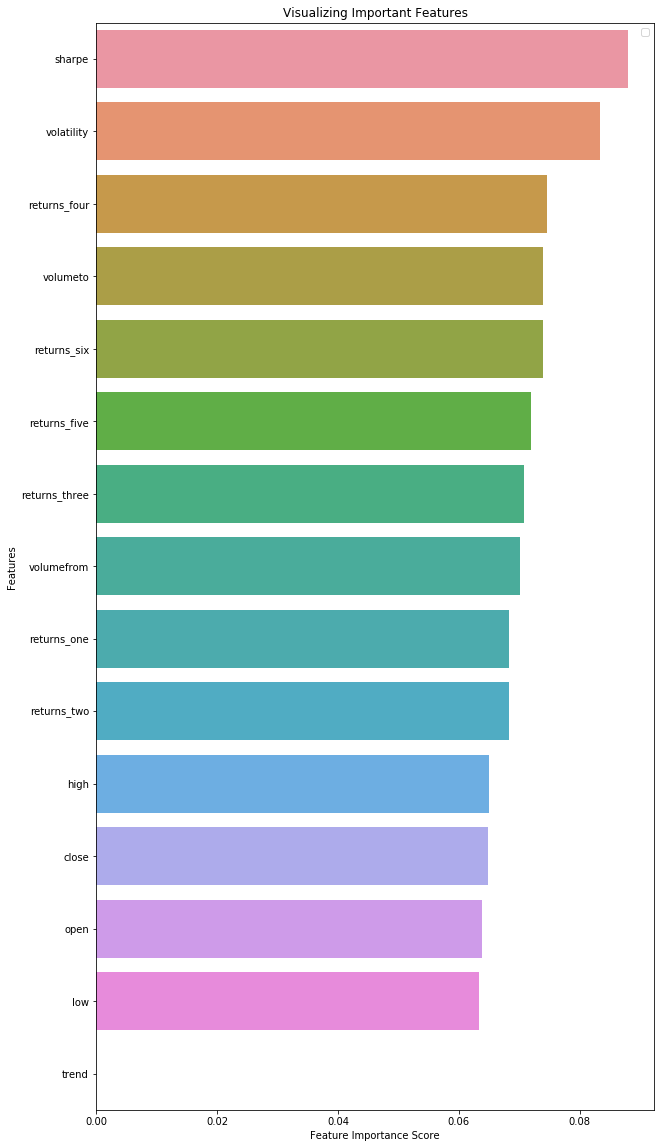

In [119]:
%matplotlib inline
plt.figure(figsize=(10,20))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [112]:
chosen_coin = 'ETH'

url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+chosen_coin+'&tsym=BTC&limit=300&aggregate=1&e=CCCAGG'
req = requests.get(url).json()
eth_data = req['Data']

In [113]:
def calc_factors(data):
    for i in range(len(data)-6):
        
        returns_one = ((data[i+1]['close']/data[i]['close'])-1)*100
        returns_two = ((data[i+2]['close']/data[i]['close'])-1)*100
        returns_three = ((data[i+3]['close']/data[i]['close'])-1)*100
        returns_four = ((data[i+4]['close']/data[i]['close'])-1)*100
        returns_five = ((data[i+5]['close']/data[i]['close'])-1)*100
        returns_six = ((data[i+6]['close']/data[i]['close'])-1)*100
        
        data[i+1]['returns_one'] = returns_one
        data[i+2]['returns_two'] = returns_two
        data[i+3]['returns_three'] = returns_three
        data[i+4]['returns_four'] = returns_four
        data[i+5]['returns_five'] = returns_five
        data[i+6]['returns_six'] = returns_six
        
        if returns_one >= 0:
            data[i]['up_one'] = 1
        else:
            data[i]['up_one'] = 0
            
        if returns_two >= 0:
            data[i]['up_two'] = 1
        else:
            data[i]['up_two'] = 0
            
        if returns_three >= 0:
            data[i]['up_three'] = 1
        else:
            data[i]['up_three'] = 0
            
        if returns_four >= 0:
            data[i]['up_four'] = 1
        else:
            data[i]['up_four'] = 0
            
        if returns_five >= 0:
            data[i]['up_five'] = 1
        else:
            data[i]['up_five'] = 0
            
        if returns_six >= 0:
            data[i]['up_six'] = 1
        else:
            data[i]['up_six'] = 0
    
    
    for i in range(len(data)-30):
    
        array = [data[j]['close'] for j in range(i, i+30)]
        volatility = (np.std(array)/np.mean(array))*100
        data[i+30]['volatility'] = volatility
        sharpe_ratio = returns_six/volatility
        data[i+30]['sharpe'] = sharpe_ratio
        rm30 = np.mean([data[j]['close'] for j in range(i, i+30)])
        rm15 = np.mean([data[j]['close'] for j in range(i+15, i+30)])
        if rm6 > rm12:
            data[i+30]['trend'] = 1
        else:
            data[i+30]['trend'] = 0
    return data[30:-12], data[-12:-6]

In [114]:
older_data, new_data = calc_factors(eth_data)

In [127]:
test_frame = []

coin_data = []
for key in ['time']+sample_keys:
    if key == 'time':
        array = [from_ts(dict_[key]) for dict_ in older_data]
    else:
        array = [dict_[key] for dict_ in older_data]
    coin_data.append(array)
df = pd.DataFrame(coin_data)
df = df.transpose()
df.columns = ['time']+sample_keys
print(df)
test_dataFrame = pd.DataFrame(df)

                    time    close     high      low     open volumefrom  \
0    2018-08-08 15:00:00  0.05644  0.05666  0.05641  0.05663    45207.4   
1    2018-08-08 16:00:00   0.0565  0.05661  0.05643  0.05644    34398.8   
2    2018-08-08 17:00:00  0.05594  0.05652  0.05551  0.05651    51071.6   
3    2018-08-08 18:00:00  0.05666  0.05677  0.05593  0.05594    50985.8   
4    2018-08-08 19:00:00  0.05666  0.05673  0.05575  0.05666    49455.2   
5    2018-08-08 20:00:00  0.05698   0.0572  0.05645  0.05667    47536.9   
6    2018-08-08 21:00:00  0.05711  0.05745  0.05697  0.05698    42186.4   
7    2018-08-08 22:00:00  0.05731  0.05732    0.057  0.05711    30871.1   
8    2018-08-08 23:00:00  0.05661  0.05733  0.05658  0.05731    24693.1   
9    2018-09-08 00:00:00  0.05682  0.05683  0.05643  0.05661    26487.5   
10   2018-09-08 01:00:00  0.05616  0.05697  0.05615  0.05682    27871.5   
11   2018-09-08 02:00:00  0.05659  0.05676  0.05613  0.05616    27811.3   
12   2018-09-08 03:00:00 

## eth_pred generates the actual predictions for the above test_dataFrame

In [122]:
X_test = test_dataFrame[sample_keys]
#eth_test = test_dataFrame['up_six']
eth_pred=classifier.predict(X_test)
#print("Accuracy:",metrics.accuracy_score(eth_test, eth_pred))

In [155]:
eth_pred

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [144]:
test_dataFrame.loc[test_dataFrame['time'] == '2018-18-08 04:00:00']['close']

229    0.04815
Name: close, dtype: object

In [135]:
eth_pred[229]

0.0

In [131]:
check_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=ETH&tsym=BTC&limit=50&aggregate=1&e=CCCAGG'
req = requests.get(check_url).json()
check_eth_data = req['Data']

In [ ]:
for dict_ in check_eth_data:
    dict_['time'] = from_ts(dict_['time'])

In [142]:
for dict_ in check_eth_data:
    if dict_['time'] == '2018-18-08 10:00:00':
        print(dict_['time'], dict_['close'])

2018-18-08 10:00:00 0.04733
